# MLiA Ch. 6: support vector machines

## SVM classifier 목적 함수 수식화 

원래의 문제는 classifier($\mathbf{w}$, $b$)가 만드는 hyperplane과 support vector 간 margin($\frac{2}{\lVert\mathbf{w}\rVert}$)을 N개의 선형 부등식(N개의 training data는 hyperplane과의 거리 모두 1 이상)의 제약 아래에서 최대화하는 문제

> $ \underset{\mathbf{w}}{\operatorname{arg\,max}}\,\frac{2}{\lVert\mathbf{w}\rVert}$
>
> subject to $t_i(\mathbf{w}^T\mathbf{x}_i+b)\geq 1$ for $i=1,\dots,N $

Convex function의 최소화 문제로 풀 수 있도록 목적 함수 변형

> $ \underset{\mathbf{w}}{\operatorname{arg\,min}}\,J(\mathbf{w})=\frac{1}{2}{\lVert\mathbf{w}\rVert}^2$
>
> subject to $ t_i(\mathbf{w}^T\mathbf{x}_i+b)\geq 1$ for $i=1,\dots,N $

불완전한 분리 상황도 해결할 수 있도록 slack variable($\xi$) 허용하고 사용자 지정 regularization parameter($C$)로 비중을 조절하는 문제로 확장

> $ \underset{\mathbf{w}}{\operatorname{arg\,min}}\,J(\mathbf{w,\xi})=\frac{1}{2}{\lVert\mathbf{w}\rVert}^2+C\sum^N_{i=1}\xi_i $
>
> subject to $ t_i(\mathbf{w}^T\mathbf{x}_i+b)\geq 1-\xi$ for $i=1,\dots,N $

목적 함수와 제약 조건들을 합쳐 Lagrangian 함수를 만들고, KKT(Karush-Kuhn-Tucker) 조건, convex optimization 문제에 대한 Wolfe dual 표현 적용하여 등식 조건 아래 다음을 최대화하는 $\alpha_i$(Lagrange multiplier)를 구하는 문제로 변형(비선형 분류 시 kernel trick 적용 위해)

> $ \underset{\mathbf{\alpha}}{\operatorname{arg\,max}}\,\tilde{L}(\mathbf{\alpha})=\sum^N_{i=1}\alpha_i - \frac{1}{2}\sum^N_{i=1}\sum^N_{j=1} \alpha_i\alpha_j t_i t_j \mathbf{x}_i^T \mathbf{x}_j$
>
> subject to $ \sum^N_{i=1}\alpha_i t_i=0 $ and $ 0\leq\alpha_i\leq C$ for $i=1, \dots , N $

- 참고
  - 오일석, "패턴인식," 교보문고, 2008
  - 한학용, "패턴인식 개론," 한빛미디어, 2009
  - Support Vector Machine Tutorial, http://www.slideshare.net/JungkyuLee1/svm-4rd-edition
  - C. Burges, "A tutorial on support vector machines for pattern recognition," Data Mining and Knowledge Discovery, 1998
  - S. Theodoridis and K. Koutroumbas, "Pattern Recognition," Elsevier, 2009

## SMO 알고리즘 이용한 SVM 학습 

여러 가지 변환을 통해 학습을 좀더 쉬운 문제로 바꾸었으나 수많은 2차 항(약 $\frac{N^2}{2}$개)이 포함된 quadratic programming 문제로 여전히 풀기 어려우며 SMO, cutting-plane 등의 알고리즘들을 이용하여 수치적으로 최적 classifier를 탐색 

- SMO(Sequential Minimal Optimization): 1996년 John Platt이 발표한 SVM 학습 알고리즘으로 한 번에 $\sum^N_{i=1}\alpha_i t_i=0 $ 제약 만족할 수 있는 최소 변경 단위인 두 개의 $\alpha$ 값만 변수로 정하고 나머지 $\alpha$ 값들은 고정한 상태에서 최적화를 수행한 후 $\alpha$의 쌍을 바꾸어가며 단계적으로 SVM 최적화 문제를 풀어 나감

> Repeat till convergence {
>
> 1. Select some pair $\alpha_i$ and $\alpha_j$ to update next (using a heuristic that tries to pick the two that will allow us to make the biggest progress towards the global maximum).
>
> 2. Reoptimize $\tilde{L}(\alpha)$ with respect to $\alpha_i$ and $\alpha_j$, while holding all the other $\alpha_k$’s ($k \neq i, j$) fixed.
>
> }

- 참고
  - J. Platt, "Sequetial minimal optimization: A fast algorithm for training support vector machines," Technical Report MST-TR-98-14, Microsoft Research,1998
  - J. Platt, "Fast Training of Support Vector Machines Using Sequential Minimal Optimization," Advances in Kernel Methods - Support Vector Learning, 1998
  - ___, "Sequential Minimal Optimization for SVM," ftp://www.ai.mit.edu/pub/users/tlp/projects/svm/svm-smo/smo.pdf
  - Andrew Ng, "The Simplified SMO Algorithm," Lecture Notes for Stanford CS229 in Autumn 2009. http://cs229.stanford.edu/materials/smo.pdf

### Helper functions

Training data loading, random number generation, clipping

In [242]:
from numpy import *
from time import sleep

def loadDataSet(fileName):
    dataMat = []; labelMat = []
    fr = open(fileName)
    for line in fr.readlines():
        lineArr = line.strip().split('\t')
        dataMat.append([float(lineArr[0]), float(lineArr[1])])
        labelMat.append(float(lineArr[2]))
    return dataMat,labelMat

def selectJrand(i,m):
    j=i #we want to select any J not equal to i
    while (j==i):
        j = int(random.uniform(0,m))
    return j

def clipAlpha(aj,H,L):
    if aj > H: 
        aj = H
    if L > aj:
        aj = L
    return aj

In [243]:
dataArr,labelArr = loadDataSet('testSet.txt')

In [244]:
shape(dataArr),shape(labelArr)

((100, 2), (100,))

### Simplified SMO

(실행 시간 측면) 최적의 첫 번째 $\alpha$를 선택하는 절차를 생략하고, 모든 $\alpha$를 첫 번째 탐색 대상으로 선택하는 version부터 시작(최적화 대상 pair가 될 두 번째 $\alpha$는 random하게 선택)

- 'numpy' matrix 연산
    - multiply(x, y): matrix x와 y의 element-wise multiplication
    - x * y: matrix x와 y의 matrix multiplication
    
- SVM classifier 출력 계산 code    
    ```python
    fXi = float(multiply(alphas,labelMat).T*(dataMatrix*dataMatrix[i,:].T)) + b
    ```
    - $ d(\mathbf{x})=\sum_{\mathbf{x}_k\in Y}\alpha_k t_k \mathbf{x}_k^T \mathbf{x} + b=\sum_{\mathbf{x}_k\in Y}\alpha_k t_k (\mathbf{x}_k \cdot \mathbf{x}) + b$ 
    
    ($d(\mathbf{x})\gt 0$이면 $\mathbf{x}\in \omega_1$, $d(\mathbf{x})\lt 0$이면 $\mathbf{x}\in \omega_2$)
    
- 최적화 진행 여부 판별 code
    ```python
    if ((labelMat[i]*Ei < -toler) and (alphas[i] < C)) or ((labelMat[i]*Ei > toler) and (alphas[i] > 0)):
    ```
    - Bounded case($\alpha$가 0 또는 C)가 아니면서 KKT 조건을 위반한 경우 최적화를 계속 진행함
    - $\alpha$의 값이 bounded case가 되면 잘 변하지 않으므로 최적화 과정에서 제외
    - 참고
      - '1.5. The KKT conditions' in 'Sequential Minimal Optimization for SVM'(ftp://www.ai.mit.edu/pub/users/tlp/projects/svm/svm-smo/smo.pdf)
      - Eq. (12) in 'Sequetial minimal optimization: A fast algorithm for training support vector machines'

In [245]:
def smoSimple(dataMatIn, classLabels, C, toler, maxIter):
    dataMatrix = mat(dataMatIn); labelMat = mat(classLabels).transpose()
    b = 0; m,n = shape(dataMatrix)    # m: training data vector 개수, n: training data vector의 차원 수(feature 개수)
    alphas = mat(zeros((m,1)))
    iter = 0
    while (iter < maxIter):
        alphaPairsChanged = 0
        # Training data vector set에 대해 순차 수행
        for i in range(m):          
            # fxi = i번째 data vector에 대한 현재까지 훈련된 classifier 함수 적용 결과
            # NOTE: multiply(): element-wise multiplication (NOT matrix multiplication), '*': matrix multiplication
            fXi = float(multiply(alphas,labelMat).T*(dataMatrix*dataMatrix[i,:].T)) + b   
            # Ei = i번째 data vector에 대한 error(예측치-정답)
            Ei = fXi - float(labelMat[i])#if checks if an example violates KKT conditions
            # KKT condition을 위반하는 경우 최적화를 계속 진행함(조건 비교 시 입력 인자로 받은 tolerance('toler')는 허용)
            if ((labelMat[i]*Ei < -toler) and (alphas[i] < C)) or ((labelMat[i]*Ei > toler) and (alphas[i] > 0)):
                # alpha_i와 함께 최적화 대상 pair가 될 alpha_j를 random하게 선택
                j = selectJrand(i,m)
                # fxj = j번째 data vector에 대한 현재까지 훈련된 classifier 함수 적용 결과
                fXj = float(multiply(alphas,labelMat).T*(dataMatrix*dataMatrix[j,:].T)) + b
                # Ej = j번째 data vector에 대한 error(예측치-정답)
                Ej = fXj - float(labelMat[j])
                # 새로운 alpha 값에 의해 update되기 전에 현재 값 backup
                alphaIold = alphas[i].copy(); alphaJold = alphas[j].copy();
                # alpha에 대한 두 가지 제약을 만족하는 새로운 alpha_j의 변경 가능 범위 설정(L<=alpha_j<H)
                # (i, j 제외 나머지 alpha는 모두 상수로 간주되므로 선형 등식 제약 조건에 의해 alpha_j 결정되면 alpha_i도 함께 결정됨
                #  Training data i와 j의 label이 다른 경우 alpha_i - alpha_j = constant
                #  Training data i와 j의 label이 같은 경우 alpha_i + alpha_j = constant)
                if (labelMat[i] != labelMat[j]):
                    L = max(0, alphas[j] - alphas[i])
                    H = min(C, C + alphas[j] - alphas[i])
                else:
                    L = max(0, alphas[j] + alphas[i] - C)
                    H = min(C, alphas[j] + alphas[i])
                # alpha가 더 움직일 여지가 없음. 다음 data sample로 넘어감.
                if L==H: print "L==H"; continue
                # eta = 목적 함수의 이차 미분값(alpha_i와 alpha_j의 선형 조합이 constant 조건 아래에서(즉 나머지 alpha는 constant))
                eta = 2.0 * dataMatrix[i,:]*dataMatrix[j,:].T - dataMatrix[i,:]*dataMatrix[i,:].T - dataMatrix[j,:]*dataMatrix[j,:].T
                # eta가 0 이상이면 비정상적 상황(잘못된 classification?) => 다음 단계로 skip
                # (정상 분류 상황이라면 목적 함수는 alpha_j(또는 alpha_i)의 concave function)
                if eta >= 0: print "eta>=0"; continue
                # eta가 음수이면 정상 상황
                # eta와 현재 error 값(Ei, Ej)을 가지고 목적 함수의 최대값 방향으로 이동하는 새로운 alpha_j 값을 결정함
                alphas[j] -= labelMat[j]*(Ei - Ej)/eta
                alphas[j] = clipAlpha(alphas[j],H,L)
                # alpha 값의 증감분이 특정 수준 이하인 경우 더 이상 최적화 진행하지 않고 다음 단계로 skip(최적화 완료?)
                if (abs(alphas[j] - alphaJold) < 0.00001): print "j not moving enough"; continue
                # 새롭게 결정된 alpha_j 값으로부터 새로운 alpha_i 값 도출
                alphas[i] += labelMat[j]*labelMat[i]*(alphaJold - alphas[j])#update i by the same amount as j
                                                                        #the update is in the oppostie direction
                # 새로운 b 값의 결정
                b1 = b - Ei- labelMat[i]*(alphas[i]-alphaIold)*dataMatrix[i,:]*dataMatrix[i,:].T - labelMat[j]*(alphas[j]-alphaJold)*dataMatrix[i,:]*dataMatrix[j,:].T
                b2 = b - Ej- labelMat[i]*(alphas[i]-alphaIold)*dataMatrix[i,:]*dataMatrix[j,:].T - labelMat[j]*(alphas[j]-alphaJold)*dataMatrix[j,:]*dataMatrix[j,:].T
                if (0 < alphas[i]) and (C > alphas[i]): b = b1
                elif (0 < alphas[j]) and (C > alphas[j]): b = b2
                else: b = (b1 + b2)/2.0
                #여기까지 continue 없이 진행되면 alpha에 대한 update가 진행되었음을 mark
                alphaPairsChanged += 1
                print "iter: %d i:%d, pairs changed %d" % (iter,i,alphaPairsChanged)
        # 이전 단계의 for loop에서 alpha 쌍에 대한 update가 전혀 없었던 경우 1회의 iteration이 완료된 것으로 간주
        if (alphaPairsChanged == 0): iter += 1
        else: iter = 0
        print "iteration number: %d" % iter
    return b,alphas

In [246]:
b,alphas = smoSimple(dataArr, labelArr, 0.6, 0.001, 40)

iter: 0 i:0, pairs changed 1
L==H
L==H
L==H
iter: 0 i:11, pairs changed 2
L==H
L==H
j not moving enough
L==H
j not moving enough
iter: 0 i:29, pairs changed 3
j not moving enough
L==H
j not moving enough
j not moving enough
j not moving enough
L==H
L==H
iter: 0 i:54, pairs changed 4
iter: 0 i:55, pairs changed 5
j not moving enough
j not moving enough
L==H
j not moving enough
iter: 0 i:92, pairs changed 6
iteration number: 0
j not moving enough
j not moving enough
L==H
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iter: 0 i:35, pairs changed 1
L==H
L==H
j not moving enough
j not moving enough
j not moving enough
L==H
j not moving enough
L==H
j not moving enough
L==H
j not moving enough
iteration number: 0
j not moving enough
L==H
j not moving enough
j not moving enough
iter: 0 i:12, pairs changed 1
L==H
iter: 0 i:23, pairs changed 2
j not moving enough
j not moving enough
j

In [247]:
alphas[alphas>0],b

(matrix([[ 0.10278709,  0.25514009,  0.01564302,  0.34228415]]),
 matrix([[-3.79569473]]))

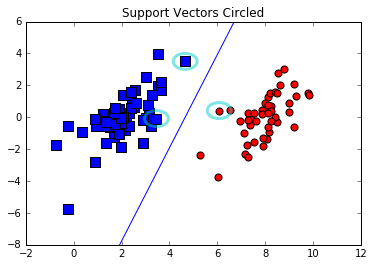

<module 'plotSupportVectors' from 'plotSupportVectors.pyc'>

In [248]:
%matplotlib inline
import plotSupportVectors
reload(plotSupportVectors)

### Full SMO

Full SMO는 조건부로 첫 번째 $\alpha$의 후보를 선택하는 outer loop을 추가하여 이전의 simplified version에 비해 실행 속도를 높임

- 'optStruct' class: (OOP 라기보다는) coding 편의성 위해 training 과정 중 사용할 관련 자료 구조를 class 이용 새로 정의
- 'calcEk(oS, k)' 함수: k 번째 training data의 error 구하는 함수(이전 code에서 inline으로 수행한 Ei, Ej 계산 과정과 동일)
- 'selectJ(i, oS, Ei)' 함수: i와 Ei(i번째 data에 대한 error)가 주어졌을 때 두 번째 alpha(alpha_j)를 선택하고 Ej를 계산하는 함수

  > __numpy.nonzero(a)__
  >
  >    Return the indices of the elements that are non-zero.
  >
  >    Returns a tuple of arrays, one for each dimension of a, containing the indices of the non-zero elements in that dimension. The result of this is always a 2-D array, with a row for each non-zero element.
  ```{python}
  >>> a = np.array([[1,2,3],[4,5,6],[7,8,9]])
  >>> a > 3
  array([[False, False, False],
       [ True,  True,  True],
       [ True,  True,  True]], dtype=bool)
  >>> np.nonzero(a > 3)
  (array([1, 1, 1, 2, 2, 2]), array([0, 1, 2, 0, 1, 2]))
  ``` 

- 'innerL(i, oS)' 함수: 최적 alpha 탐색 수행 함수로 smoSimple()과 거의 동일하나, 두 번째 alpha(j) 선택 시 random 아닌 selectJ() 사용하여 최적화 적용한 점과 새로 정의한 optStruct 자료 구조 사용한다는 점에서 다름
- 'smoP(dataMatIn, classLabels, C, toler, maxIter)' 함수: smoSimple()에 비해 복잡한 종료 조건을 채택하여 실행 시간 최적화. alpha의 변경 여부와 관계 없이 iteration count는 증가하며, 단 현재 iteration에서의 alpha 변경 여부에 따라 다음 iteration을 모든 i 값에 대해 innerL() 함수 실행하며 최적화할 것인지 또는 non-bound case에 대해서만 탐색할 것인지를 동적으로 결정

In [249]:
'''#######********************************
Non-Kernel VErsions below
'''#######********************************

class optStructK:
    def __init__(self,dataMatIn, classLabels, C, toler):  # Initialize the structure with the parameters 
        self.X = dataMatIn
        self.labelMat = classLabels
        self.C = C
        self.tol = toler
        self.m = shape(dataMatIn)[0]
        self.alphas = mat(zeros((self.m,1)))
        self.b = 0
        self.eCache = mat(zeros((self.m,2))) #first column is valid flag
        
def calcEkK(oS, k):
    fXk = float(multiply(oS.alphas,oS.labelMat).T*(oS.X*oS.X[k,:].T)) + oS.b
    Ek = fXk - float(oS.labelMat[k])
    return Ek
        
def selectJK(i, oS, Ei):         #this is the second choice -heurstic, and calcs Ej
    maxK = -1; maxDeltaE = 0; Ej = 0
    oS.eCache[i] = [1,Ei]  #set valid #choose the alpha that gives the maximum delta E
    # Error cache('eCache') 내 valid entry의 row index를 추출
    # - os.eCache[:,0] : matrix 'os.eCache'의 첫 번째 column을 선택함(즉, valid flag)
    # - os.eCache[:,0].A : 'os.eCache[:,0]' 자료 구조를 matrix에서 array로 바꿈(=array(os.eCache[:,0])
    # - nonzero(...): array type인자의 non-zero element의 index들의 list를 각 차원 별 생성, 반환
    # - nonzero(...).[0]: non-zero element의 list 중 row-major list를 선택
    validEcacheList = nonzero(oS.eCache[:,0].A)[0]
    # Error cache 내에 non-zero element가 두 개 이상인 경우(즉 cache 내 i외 다른 valid entry 존재하는 경우) 
    # 해당 index의
    if (len(validEcacheList)) > 1:
        for k in validEcacheList:   #loop through valid Ecache values and find the one that maximizes delta E
            if k == i: continue #don't calc for i, waste of time
            # i아닌 valid entry에 대한 error, Ek를 계산
            Ek = calcEkK(oS, k)
            deltaE = abs(Ei - Ek)
            # Ek 중 Ei와 가장 큰 차이를 보이는 k로 current best 후보를 update
            if (deltaE > maxDeltaE):
                maxK = k; maxDeltaE = deltaE; Ej = Ek
        return maxK, Ej
    # Error cache 내 i외 valid entry 존재하지 않는 경우 두 번째 alpha 후보를 random하게 선택하고 error 계산
    else:   #in this case (first time around) we don't have any valid eCache values
        j = selectJrand(i, oS.m)
        Ej = calcEkK(oS, j)
    return j, Ej

def updateEkK(oS, k):#after any alpha has changed update the new value in the cache
    Ek = calcEkK(oS, k)
    # Update된 'Ek' 값이 실제 참조되고 있는지???
    oS.eCache[k] = [1,Ek]    
        
def innerLK(i, oS):
    Ei = calcEkK(oS, i)
    # smoSimple()과 동일한 KKT 조건 위반 여부 check
    if ((oS.labelMat[i]*Ei < -oS.tol) and (oS.alphas[i] < oS.C)) or ((oS.labelMat[i]*Ei > oS.tol) and (oS.alphas[i] > 0)):
        # 두 번째 alpha 탐색 후보 선택 결정 함수 실행(smoSimple()에서의 임의 선택)
        j,Ej = selectJK(i, oS, Ei) #this has been changed from selectJrand
        # j 선택 이후는 smoSimple()과 동일
        alphaIold = oS.alphas[i].copy(); alphaJold = oS.alphas[j].copy();
        if (oS.labelMat[i] != oS.labelMat[j]):
            L = max(0, oS.alphas[j] - oS.alphas[i])
            H = min(oS.C, oS.C + oS.alphas[j] - oS.alphas[i])
        else:
            L = max(0, oS.alphas[j] + oS.alphas[i] - oS.C)
            H = min(oS.C, oS.alphas[j] + oS.alphas[i])
        if L==H: print "L==H"; return 0
        eta = 2.0 * oS.X[i,:]*oS.X[j,:].T - oS.X[i,:]*oS.X[i,:].T - oS.X[j,:]*oS.X[j,:].T
        if eta >= 0: print "eta>=0"; return 0
        oS.alphas[j] -= oS.labelMat[j]*(Ei - Ej)/eta
        oS.alphas[j] = clipAlpha(oS.alphas[j],H,L)
        # Error cache의 update 수행
        # Cache 내 저장된 error 값이 실제 참조되고 있는지???(Valid flag는 참조되고 있음)
        updateEkK(oS, j) #added this for the Ecache
        if (abs(oS.alphas[j] - alphaJold) < 0.00001): print "j not moving enough"; return 0
        oS.alphas[i] += oS.labelMat[j]*oS.labelMat[i]*(alphaJold - oS.alphas[j])#update i by the same amount as j
        updateEkK(oS, i) #added this for the Ecache                    #the update is in the oppostie direction
        b1 = oS.b - Ei- oS.labelMat[i]*(oS.alphas[i]-alphaIold)*oS.X[i,:]*oS.X[i,:].T - oS.labelMat[j]*(oS.alphas[j]-alphaJold)*oS.X[i,:]*oS.X[j,:].T
        b2 = oS.b - Ej- oS.labelMat[i]*(oS.alphas[i]-alphaIold)*oS.X[i,:]*oS.X[j,:].T - oS.labelMat[j]*(oS.alphas[j]-alphaJold)*oS.X[j,:]*oS.X[j,:].T
        if (0 < oS.alphas[i]) and (oS.C > oS.alphas[i]): oS.b = b1
        elif (0 < oS.alphas[j]) and (oS.C > oS.alphas[j]): oS.b = b2
        else: oS.b = (b1 + b2)/2.0
        return 1
    else: return 0

def smoPK(dataMatIn, classLabels, C, toler, maxIter):    #full Platt SMO
    oS = optStructK(mat(dataMatIn),mat(classLabels).transpose(),C,toler)
    iter = 0
    entireSet = True; alphaPairsChanged = 0
    while (iter < maxIter) and ((alphaPairsChanged > 0) or (entireSet)):
        alphaPairsChanged = 0
        if entireSet:   #go over all
            for i in range(oS.m):        
                alphaPairsChanged += innerLK(i,oS)
                print "fullSet, iter: %d i:%d, pairs changed %d" % (iter,i,alphaPairsChanged)
            iter += 1
        else:#go over non-bound (railed) alphas
            nonBoundIs = nonzero((oS.alphas.A > 0) * (oS.alphas.A < C))[0]
            for i in nonBoundIs:
                alphaPairsChanged += innerLK(i,oS)
                print "non-bound, iter: %d i:%d, pairs changed %d" % (iter,i,alphaPairsChanged)
            iter += 1
        if entireSet: entireSet = False #toggle entire set loop
        elif (alphaPairsChanged == 0): entireSet = True  
        print "iteration number: %d" % iter
    return oS.b,oS.alphas

In [250]:
dataArr,labelArr = loadDataSet('testSet.txt')
b,alphas = smoPK(dataArr, labelArr, 0.6, 0.001, 40)

L==H
fullSet, iter: 0 i:0, pairs changed 0
L==H
fullSet, iter: 0 i:1, pairs changed 0
fullSet, iter: 0 i:2, pairs changed 1
L==H
fullSet, iter: 0 i:3, pairs changed 1
fullSet, iter: 0 i:4, pairs changed 2
fullSet, iter: 0 i:5, pairs changed 2
fullSet, iter: 0 i:6, pairs changed 2
j not moving enough
fullSet, iter: 0 i:7, pairs changed 2
L==H
fullSet, iter: 0 i:8, pairs changed 2
fullSet, iter: 0 i:9, pairs changed 2
L==H
fullSet, iter: 0 i:10, pairs changed 2
L==H
fullSet, iter: 0 i:11, pairs changed 2
L==H
fullSet, iter: 0 i:12, pairs changed 2
fullSet, iter: 0 i:13, pairs changed 2
L==H
fullSet, iter: 0 i:14, pairs changed 2
fullSet, iter: 0 i:15, pairs changed 2
fullSet, iter: 0 i:16, pairs changed 2
L==H
fullSet, iter: 0 i:17, pairs changed 2
fullSet, iter: 0 i:18, pairs changed 3
fullSet, iter: 0 i:19, pairs changed 3
fullSet, iter: 0 i:20, pairs changed 3
fullSet, iter: 0 i:21, pairs changed 3
j not moving enough
fullSet, iter: 0 i:22, pairs changed 3
L==H
fullSet, iter: 0 i:23, 

In [251]:
alphas[alphas>0],b

(matrix([[ 0.06961952,  0.0169055 ,  0.0169055 ,  0.0272699 ,  0.04522972,
           0.0272699 ,  0.0243898 ,  0.06140181,  0.06140181]]),
 matrix([[-2.89901748]]))

smoP()(full Platt's SMO algorithm)은 smoSimple()보다 빨리 수행된다.

In [252]:
b,alphas = smoPK(dataArr, labelArr, 1, 0.001, 40)

fullSet, iter: 0 i:0, pairs changed 1
fullSet, iter: 0 i:1, pairs changed 1
fullSet, iter: 0 i:2, pairs changed 1
fullSet, iter: 0 i:3, pairs changed 1
fullSet, iter: 0 i:4, pairs changed 1
fullSet, iter: 0 i:5, pairs changed 1
fullSet, iter: 0 i:6, pairs changed 1
fullSet, iter: 0 i:7, pairs changed 1
fullSet, iter: 0 i:8, pairs changed 2
fullSet, iter: 0 i:9, pairs changed 2
fullSet, iter: 0 i:10, pairs changed 3
fullSet, iter: 0 i:11, pairs changed 3
fullSet, iter: 0 i:12, pairs changed 3
fullSet, iter: 0 i:13, pairs changed 3
fullSet, iter: 0 i:14, pairs changed 3
fullSet, iter: 0 i:15, pairs changed 3
fullSet, iter: 0 i:16, pairs changed 3
L==H
fullSet, iter: 0 i:17, pairs changed 3
fullSet, iter: 0 i:18, pairs changed 3
fullSet, iter: 0 i:19, pairs changed 3
fullSet, iter: 0 i:20, pairs changed 3
fullSet, iter: 0 i:21, pairs changed 3
fullSet, iter: 0 i:22, pairs changed 3
L==H
fullSet, iter: 0 i:23, pairs changed 3
fullSet, iter: 0 i:24, pairs changed 3
fullSet, iter: 0 i:25, pa

In [253]:
alphas[alphas>0],b

(matrix([[ 0.04916579,  0.05794998,  0.16680268,  0.02385687,  0.02385687,
           0.10711577,  0.16680268]]), matrix([[-3.57974049]]))

### Classification 수행

Test 입력($\mathbf{x}$)에 대한 classification 수행하기 위해 SMO 통해 구한 Largange multiplier($\mathbf{\alpha}$) 값들과 training data(중 support vector)로부터 classifier parameter $\mathbf{w}$ 값을 구하고, $\mathbf{w}^T\mathbf{x}+b$ 값의 부호로부터 최종 결과를 얻음

> $\mathbf{w}^T\mathbf{x}+b \gt 0$이면 class 1, $\mathbf{w}^T\mathbf{x}+b \lt 0$이면 class -1

- 'calcWs()' 함수: smoP() 수행하여 얻은 alpha의 set으로부터 w 값을 계산함. 이때 non-zero alpha 값의 training data 값(support vector)만 기여

In [254]:
def calcWs(alphas,dataArr,classLabels):
    X = mat(dataArr); labelMat = mat(classLabels).transpose()
    m,n = shape(X)
    w = zeros((n,1))
    for i in range(m):
        w += multiply(alphas[i]*labelMat[i],X[i,:].T)
    return w

In [255]:
ws=calcWs(alphas,dataArr,labelArr)
ws

array([[ 0.76671715],
       [-0.19656689]])

In [256]:
datMat=mat(dataArr)
datMat[0]*mat(ws)+b, labelArr[0]

(matrix([[-1.25234746]]), -1.0)

In [257]:
labelArr[0]

-1.0

In [258]:
datMat[1]*mat(ws)+b, labelArr[1]

(matrix([[-1.76760789]]), -1.0)

In [259]:
datMat[2]*mat(ws)+b, labelArr[2]

(matrix([[ 2.52071333]]), 1.0)

### SMO including kernel trick

비선형의 classification일 필요한 경우 mapping 함수($\Phi(\mathbf{x})$)를 이용하여 선형 분리가 가능한 더 높은 차원으로 확장하여 해결 가능하며, Wolfe dual form에서는 항상 mapping 함수의 내적($K(\mathbf{x}_i, \mathbf{x}_j)$)으로 나타나므로 mapping 함수의 차원이 높아지더라도 그에 비례하여 계산 복잡도가 높아지지 않음('Kernel trick')

> $ \underset{\mathbf{\alpha}}{\operatorname{arg\,max}}\,\tilde{L}(\mathbf{\alpha})=\sum^N_{i=1}\alpha_i - \frac{1}{2}\sum^N_{i=1}\sum^N_{j=1} \alpha_i\alpha_j t_i t_j K(\mathbf{x}_i, \mathbf{x}_j) $
>
> where $K(\mathbf{x}_i, \mathbf{x}_j)=\Phi(\mathbf{x}_i)\cdot\Phi(\mathbf{x}_j)$
>
> subject to $ \sum^N_{i=1}\alpha_i t_i=0 $ and $ 0\leq\alpha_i\leq C, i=1, \dots , N $

innerL(), calcEk() 함수를 kernel 포함하도록 다음과 같이 수정함

In [260]:
class optStruct:
    def __init__(self,dataMatIn, classLabels, C, toler, kTup):  # Initialize the structure with the parameters 
        self.X = dataMatIn
        self.labelMat = classLabels
        self.C = C
        self.tol = toler
        self.m = shape(dataMatIn)[0]
        self.alphas = mat(zeros((self.m,1)))
        self.b = 0
        self.eCache = mat(zeros((self.m,2))) #first column is valid flag
        self.K = mat(zeros((self.m,self.m)))
        for i in range(self.m):
            self.K[:,i] = kernelTrans(self.X, self.X[i,:], kTup)
        
def calcEk(oS, k):
    fXk = float(multiply(oS.alphas,oS.labelMat).T*oS.K[:,k] + oS.b)
    Ek = fXk - float(oS.labelMat[k])
    return Ek
        
def selectJ(i, oS, Ei):         #this is the second choice -heurstic, and calcs Ej
    maxK = -1; maxDeltaE = 0; Ej = 0
    oS.eCache[i] = [1,Ei]  #set valid #choose the alpha that gives the maximum delta E
    validEcacheList = nonzero(oS.eCache[:,0].A)[0]
    if (len(validEcacheList)) > 1:
        for k in validEcacheList:   #loop through valid Ecache values and find the one that maximizes delta E
            if k == i: continue #don't calc for i, waste of time
            Ek = calcEk(oS, k)
            deltaE = abs(Ei - Ek)
            if (deltaE > maxDeltaE):
                maxK = k; maxDeltaE = deltaE; Ej = Ek
        return maxK, Ej
    else:   #in this case (first time around) we don't have any valid eCache values
        j = selectJrand(i, oS.m)
        Ej = calcEk(oS, j)
    return j, Ej

def updateEk(oS, k):#after any alpha has changed update the new value in the cache
    Ek = calcEk(oS, k)
    oS.eCache[k] = [1,Ek]
        
def innerL(i, oS):
    Ei = calcEk(oS, i)
    if ((oS.labelMat[i]*Ei < -oS.tol) and (oS.alphas[i] < oS.C)) or ((oS.labelMat[i]*Ei > oS.tol) and (oS.alphas[i] > 0)):
        j,Ej = selectJ(i, oS, Ei) #this has been changed from selectJrand
        alphaIold = oS.alphas[i].copy(); alphaJold = oS.alphas[j].copy();
        if (oS.labelMat[i] != oS.labelMat[j]):
            L = max(0, oS.alphas[j] - oS.alphas[i])
            H = min(oS.C, oS.C + oS.alphas[j] - oS.alphas[i])
        else:
            L = max(0, oS.alphas[j] + oS.alphas[i] - oS.C)
            H = min(oS.C, oS.alphas[j] + oS.alphas[i])
        if L==H: print "L==H"; return 0
        eta = 2.0 * oS.K[i,j] - oS.K[i,i] - oS.K[j,j] #changed for kernel
        if eta >= 0: print "eta>=0"; return 0
        oS.alphas[j] -= oS.labelMat[j]*(Ei - Ej)/eta
        oS.alphas[j] = clipAlpha(oS.alphas[j],H,L)
        updateEk(oS, j) #added this for the Ecache
        if (abs(oS.alphas[j] - alphaJold) < 0.00001): print "j not moving enough"; return 0
        oS.alphas[i] += oS.labelMat[j]*oS.labelMat[i]*(alphaJold - oS.alphas[j])#update i by the same amount as j
        updateEk(oS, i) #added this for the Ecache                    #the update is in the oppostie direction
        b1 = oS.b - Ei- oS.labelMat[i]*(oS.alphas[i]-alphaIold)*oS.K[i,i] - oS.labelMat[j]*(oS.alphas[j]-alphaJold)*oS.K[i,j]
        b2 = oS.b - Ej- oS.labelMat[i]*(oS.alphas[i]-alphaIold)*oS.K[i,j]- oS.labelMat[j]*(oS.alphas[j]-alphaJold)*oS.K[j,j]
        if (0 < oS.alphas[i]) and (oS.C > oS.alphas[i]): oS.b = b1
        elif (0 < oS.alphas[j]) and (oS.C > oS.alphas[j]): oS.b = b2
        else: oS.b = (b1 + b2)/2.0
        return 1
    else: return 0

def smoP(dataMatIn, classLabels, C, toler, maxIter,kTup=('lin', 0)):    #full Platt SMO
    oS = optStruct(mat(dataMatIn),mat(classLabels).transpose(),C,toler, kTup)
    iter = 0
    entireSet = True; alphaPairsChanged = 0
    while (iter < maxIter) and ((alphaPairsChanged > 0) or (entireSet)):
        alphaPairsChanged = 0
        if entireSet:   #go over all
            for i in range(oS.m):        
                alphaPairsChanged += innerL(i,oS)
                print "fullSet, iter: %d i:%d, pairs changed %d" % (iter,i,alphaPairsChanged)
            iter += 1
        else:#go over non-bound (railed) alphas
            nonBoundIs = nonzero((oS.alphas.A > 0) * (oS.alphas.A < C))[0]
            for i in nonBoundIs:
                alphaPairsChanged += innerL(i,oS)
                print "non-bound, iter: %d i:%d, pairs changed %d" % (iter,i,alphaPairsChanged)
            iter += 1
        if entireSet: entireSet = False #toggle entire set loop
        elif (alphaPairsChanged == 0): entireSet = True  
        print "iteration number: %d" % iter
    return oS.b,oS.alphas

#### RBF kernel 적용한 test

두 vector 간 거리의 Gaussian 형태로 표현되는 RBF(radial basis function)을 kernel로 선택하여 kernel 지원 SMO를 실행

$$ K(x,y) = exp(\frac{-\|x-y\|^2}{2\sigma^2})$$

Kernel 적용하는 경우 classification 시 support vector의 개수에 따라 계산량이 달라지게 되며, 현재 예에서는 RBF 내 $\sigma$가 작은 경우 support vector 개수 증가, $\sigma$가 큰 경우 support vector 감소함. Support vector가 너무 적으면 poor decision boundary(???) 가지며, 너무 많아지면 classification 시 계산 복잡도 높아짐(즉, k-nearest neighbor로 근접해 감)

In [261]:
def kernelTrans(X, A, kTup): #calc the kernel or transform data to a higher dimensional space
    m,n = shape(X)
    K = mat(zeros((m,1)))
    if kTup[0]=='lin': K = X * A.T   #linear kernel
    elif kTup[0]=='rbf':
        for j in range(m):
            deltaRow = X[j,:] - A
            K[j] = deltaRow*deltaRow.T
        K = exp(K/(-1*kTup[1]**2)) #divide in NumPy is element-wise not matrix like Matlab
    else: raise NameError('Houston We Have a Problem -- \
    That Kernel is not recognized')
    return K

def testRbf(k1=1.3):
    dataArr,labelArr = loadDataSet('testSetRBF.txt')
    b,alphas = smoP(dataArr, labelArr, 200, 0.0001, 10000, ('rbf', k1)) #C=200 important
    datMat=mat(dataArr); labelMat = mat(labelArr).transpose()
    svInd=nonzero(alphas.A>0)[0]
    sVs=datMat[svInd] #get matrix of only support vectors
    labelSV = labelMat[svInd];
    print "there are %d Support Vectors" % shape(sVs)[0]
    m,n = shape(datMat)
    errorCount = 0
    for i in range(m):
        kernelEval = kernelTrans(sVs,datMat[i,:],('rbf', k1))
        predict=kernelEval.T * multiply(labelSV,alphas[svInd]) + b
        if sign(predict)!=sign(labelArr[i]): errorCount += 1
    print "the training error rate is: %f" % (float(errorCount)/m)
    dataArr,labelArr = loadDataSet('testSetRBF2.txt')
    errorCount = 0
    datMat=mat(dataArr); labelMat = mat(labelArr).transpose()
    m,n = shape(datMat)
    for i in range(m):
        kernelEval = kernelTrans(sVs,datMat[i,:],('rbf', k1))
        predict=kernelEval.T * multiply(labelSV,alphas[svInd]) + b
        if sign(predict)!=sign(labelArr[i]): errorCount += 1    
    print "the test error rate is: %f" % (float(errorCount)/m)  

In [262]:
testRbf(0.1)

fullSet, iter: 0 i:0, pairs changed 1
fullSet, iter: 0 i:1, pairs changed 2
fullSet, iter: 0 i:2, pairs changed 3
fullSet, iter: 0 i:3, pairs changed 4
fullSet, iter: 0 i:4, pairs changed 5
fullSet, iter: 0 i:5, pairs changed 6
fullSet, iter: 0 i:6, pairs changed 7
fullSet, iter: 0 i:7, pairs changed 8
fullSet, iter: 0 i:8, pairs changed 9
fullSet, iter: 0 i:9, pairs changed 10
fullSet, iter: 0 i:10, pairs changed 11
fullSet, iter: 0 i:11, pairs changed 12
fullSet, iter: 0 i:12, pairs changed 12
fullSet, iter: 0 i:13, pairs changed 13
fullSet, iter: 0 i:14, pairs changed 14
fullSet, iter: 0 i:15, pairs changed 15
j not moving enough
fullSet, iter: 0 i:16, pairs changed 15
fullSet, iter: 0 i:17, pairs changed 16
fullSet, iter: 0 i:18, pairs changed 17
fullSet, iter: 0 i:19, pairs changed 18
fullSet, iter: 0 i:20, pairs changed 19
fullSet, iter: 0 i:21, pairs changed 20
fullSet, iter: 0 i:22, pairs changed 21
fullSet, iter: 0 i:23, pairs changed 22
fullSet, iter: 0 i:24, pairs changed 23

In [263]:
testRbf(1.3)

fullSet, iter: 0 i:0, pairs changed 1
fullSet, iter: 0 i:1, pairs changed 2
fullSet, iter: 0 i:2, pairs changed 3
fullSet, iter: 0 i:3, pairs changed 4
fullSet, iter: 0 i:4, pairs changed 5
fullSet, iter: 0 i:5, pairs changed 6
fullSet, iter: 0 i:6, pairs changed 6
fullSet, iter: 0 i:7, pairs changed 6
fullSet, iter: 0 i:8, pairs changed 7
fullSet, iter: 0 i:9, pairs changed 7
L==H
fullSet, iter: 0 i:10, pairs changed 7
fullSet, iter: 0 i:11, pairs changed 8
L==H
fullSet, iter: 0 i:12, pairs changed 8
L==H
fullSet, iter: 0 i:13, pairs changed 8
L==H
fullSet, iter: 0 i:14, pairs changed 8
fullSet, iter: 0 i:15, pairs changed 9
fullSet, iter: 0 i:16, pairs changed 10
L==H
fullSet, iter: 0 i:17, pairs changed 10
fullSet, iter: 0 i:18, pairs changed 11
fullSet, iter: 0 i:19, pairs changed 12
fullSet, iter: 0 i:20, pairs changed 12
fullSet, iter: 0 i:21, pairs changed 13
fullSet, iter: 0 i:22, pairs changed 13
fullSet, iter: 0 i:23, pairs changed 14
fullSet, iter: 0 i:24, pairs changed 15
f

### SVM으로 handwriting classification

2장의 kNN으로 수행했던 handwriting classification을 SVM으로 다시 수행(여기서는 binary classification만 고려하여 숫자 '1'과 '9'만 있는 training set을 사용함)

In [264]:
def img2vector(filename):
    returnVect = zeros((1,1024))
    fr = open(filename)
    for i in range(32):
        lineStr = fr.readline()
        for j in range(32):
            returnVect[0,32*i+j] = int(lineStr[j])
    return returnVect

def loadImages(dirName):
    from os import listdir
    hwLabels = []
    trainingFileList = listdir(dirName)           #load the training set
    m = len(trainingFileList)
    trainingMat = zeros((m,1024))
    for i in range(m):
        fileNameStr = trainingFileList[i]
        fileStr = fileNameStr.split('.')[0]     #take off .txt
        classNumStr = int(fileStr.split('_')[0])
        if classNumStr == 9: hwLabels.append(-1)
        else: hwLabels.append(1)
        trainingMat[i,:] = img2vector('%s/%s' % (dirName, fileNameStr))
    return trainingMat, hwLabels    

def testDigits(kTup=('rbf', 10)):
    dataArr,labelArr = loadImages('trainingDigits')
    b,alphas = smoP(dataArr, labelArr, 200, 0.0001, 10000, kTup)
    datMat=mat(dataArr); labelMat = mat(labelArr).transpose()
    svInd=nonzero(alphas.A>0)[0]
    sVs=datMat[svInd] 
    labelSV = labelMat[svInd];
    print "there are %d Support Vectors" % shape(sVs)[0]
    m,n = shape(datMat)
    errorCount = 0
    for i in range(m):
        kernelEval = kernelTrans(sVs,datMat[i,:],kTup)
        predict=kernelEval.T * multiply(labelSV,alphas[svInd]) + b
        if sign(predict)!=sign(labelArr[i]): errorCount += 1
    print "the training error rate is: %f" % (float(errorCount)/m)
    dataArr,labelArr = loadImages('testDigits')
    errorCount = 0
    datMat=mat(dataArr); labelMat = mat(labelArr).transpose()
    m,n = shape(datMat)
    for i in range(m):
        kernelEval = kernelTrans(sVs,datMat[i,:],kTup)
        predict=kernelEval.T * multiply(labelSV,alphas[svInd]) + b
        if sign(predict)!=sign(labelArr[i]): errorCount += 1    
    print "the test error rate is: %f" % (float(errorCount)/m) 

In [265]:
testDigits()

fullSet, iter: 0 i:0, pairs changed 1
fullSet, iter: 0 i:1, pairs changed 2
fullSet, iter: 0 i:2, pairs changed 3
fullSet, iter: 0 i:3, pairs changed 4
fullSet, iter: 0 i:4, pairs changed 5
fullSet, iter: 0 i:5, pairs changed 6
fullSet, iter: 0 i:6, pairs changed 7
fullSet, iter: 0 i:7, pairs changed 8
fullSet, iter: 0 i:8, pairs changed 9
fullSet, iter: 0 i:9, pairs changed 10
fullSet, iter: 0 i:10, pairs changed 11
fullSet, iter: 0 i:11, pairs changed 12
fullSet, iter: 0 i:12, pairs changed 13
fullSet, iter: 0 i:13, pairs changed 14
fullSet, iter: 0 i:14, pairs changed 15
fullSet, iter: 0 i:15, pairs changed 16
fullSet, iter: 0 i:16, pairs changed 17
fullSet, iter: 0 i:17, pairs changed 18
fullSet, iter: 0 i:18, pairs changed 19
fullSet, iter: 0 i:19, pairs changed 20
fullSet, iter: 0 i:20, pairs changed 21
fullSet, iter: 0 i:21, pairs changed 22
fullSet, iter: 0 i:22, pairs changed 23
fullSet, iter: 0 i:23, pairs changed 24
fullSet, iter: 0 i:24, pairs changed 25
fullSet, iter: 0 i:

In [266]:
testDigits(('rbf', 20))

fullSet, iter: 0 i:0, pairs changed 1
fullSet, iter: 0 i:1, pairs changed 2
fullSet, iter: 0 i:2, pairs changed 3
fullSet, iter: 0 i:3, pairs changed 4
fullSet, iter: 0 i:4, pairs changed 5
fullSet, iter: 0 i:5, pairs changed 6
fullSet, iter: 0 i:6, pairs changed 6
fullSet, iter: 0 i:7, pairs changed 7
j not moving enough
fullSet, iter: 0 i:8, pairs changed 7
fullSet, iter: 0 i:9, pairs changed 8
fullSet, iter: 0 i:10, pairs changed 9
fullSet, iter: 0 i:11, pairs changed 10
fullSet, iter: 0 i:12, pairs changed 11
fullSet, iter: 0 i:13, pairs changed 12
fullSet, iter: 0 i:14, pairs changed 13
fullSet, iter: 0 i:15, pairs changed 14
fullSet, iter: 0 i:16, pairs changed 14
fullSet, iter: 0 i:17, pairs changed 15
fullSet, iter: 0 i:18, pairs changed 16
fullSet, iter: 0 i:19, pairs changed 17
fullSet, iter: 0 i:20, pairs changed 17
fullSet, iter: 0 i:21, pairs changed 18
fullSet, iter: 0 i:22, pairs changed 19
fullSet, iter: 0 i:23, pairs changed 20
fullSet, iter: 0 i:24, pairs changed 20
f

In [267]:
testDigits(('rbf',10))

L==H
fullSet, iter: 0 i:0, pairs changed 0
fullSet, iter: 0 i:1, pairs changed 1
fullSet, iter: 0 i:2, pairs changed 2
fullSet, iter: 0 i:3, pairs changed 3
fullSet, iter: 0 i:4, pairs changed 4
fullSet, iter: 0 i:5, pairs changed 5
fullSet, iter: 0 i:6, pairs changed 6
fullSet, iter: 0 i:7, pairs changed 7
fullSet, iter: 0 i:8, pairs changed 8
fullSet, iter: 0 i:9, pairs changed 9
fullSet, iter: 0 i:10, pairs changed 10
fullSet, iter: 0 i:11, pairs changed 11
fullSet, iter: 0 i:12, pairs changed 12
fullSet, iter: 0 i:13, pairs changed 13
fullSet, iter: 0 i:14, pairs changed 14
fullSet, iter: 0 i:15, pairs changed 15
fullSet, iter: 0 i:16, pairs changed 16
fullSet, iter: 0 i:17, pairs changed 17
fullSet, iter: 0 i:18, pairs changed 18
fullSet, iter: 0 i:19, pairs changed 19
fullSet, iter: 0 i:20, pairs changed 20
fullSet, iter: 0 i:21, pairs changed 21
fullSet, iter: 0 i:22, pairs changed 22
fullSet, iter: 0 i:23, pairs changed 23
fullSet, iter: 0 i:24, pairs changed 24
fullSet, iter: 

Kernel과 C를 잘 설정하면 kNN에 비해 좋은 성능을 보여주며, kernel 적용하지 않는 linear classification도 나쁘지 않은 결과를 보여준다. 현재 C 값은 사용자가 임의 설정하지만, C가 최적화 과정에 포함되는 v-SVM과 같은 algorithm(참고: S. Theodoridis and K. Koutroumbas, "Pattern Recognition," Elsevier, 2009)도 존재한다.

| Kernel, settings | Training error (%) | Test error (%) | # Support vectors |
|---|---|---|---|
| RBF, 0.1 | 0 | 52 | 402 | 
| RBF, 5 | 0 | 3.2 | 402 | 
| RBF, 10 | 0 | 0.5 | 99 | 
| RBF, 50 | 0.2 | 2.2 | 41 | 
| RBF, 100 | 4.5 | 4.3 | 26 | 
| Linear | 2.7 | 2.2 | 38 | 